In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [3]:
from scipy.ndimage import rotate
from scipy.ndimage import zoom

from jax.scipy.interpolate import RegularGridInterpolator

In [4]:
from microscope_calibration.stemoverfocus import (
    solve_model_fourdstem_wrapper, 
    find_input_slopes, 
    ray_coords_at_plane,
)
from microscope_calibration.generate import compute_fourdstem_dataset, do_shifted_sum, compute_scan_grid_rays_and_intensities
from microscope_calibration import components as comp

In [5]:
import numpy as np
import jax.numpy as jnp

In [6]:
from microscope_calibration import components as comp
from microscope_calibration.model import ModelParameters, create_stem_model

In [7]:
sample_image = test_image = np.zeros((7, 9), dtype=np.uint8)
test_image[0, 0] = 1
test_image[0, -1] = 2
test_image[-1, -1] = 3
test_image[-1, 0] = 4

In [ ]:
params_dict = model_params = ModelParameters(
    semi_conv=0.000001,
    defocus=.001,
    camera_length=0.1,
    scan_shape=(7, 9),
    det_shape=(64, 64),
    scan_step=(0.001, 0.001),
    det_px_size=(0.001, 0.001),
    scan_rotation=0.0,
    descan_error = jnp.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
)

ERROR:2025-06-20 16:32:43,752:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/nobackup/mb265392/.pyenv/versions/temgym/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 135, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/nobackup/mb265392/.pyenv/versions/temgym/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/nobackup/mb265392/.pyenv/versions/temgym/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 230, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  Fi

In [9]:
stem_model = model = create_stem_model(params_dict)

In [19]:
PointSource, ScanGrid, Descanner, Detector = model

fourdstem_array = np.zeros((ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], *Detector.det_shape), dtype=np.float32)

cy, cx = np.asarray(Detector.det_shape) // 2
fourdstem_array[0, 0, cy, cx] = 1.
fourdstem_array[0, -1, cy, cx] = 2.
fourdstem_array[-1, -1, cy, cx] = 3.
fourdstem_array[-1, 0, cy, cx] = 4.
fourdstem_array = fourdstem_array.reshape(-1, *Detector.det_shape)

sample_px_ys, sample_px_xs, detector_intensities = compute_scan_grid_rays_and_intensities(
    stem_model, fourdstem_array
)

sample_px_ys = np.array(sample_px_ys, dtype=np.int32).flatten()
sample_px_xs = np.array(sample_px_xs, dtype=np.int32).flatten()
detector_intensities = np.array(detector_intensities, dtype=np.float32).flatten()

Scan Y: 100%|██████████| 63/63 [00:00<00:00, 3737.29it/s]


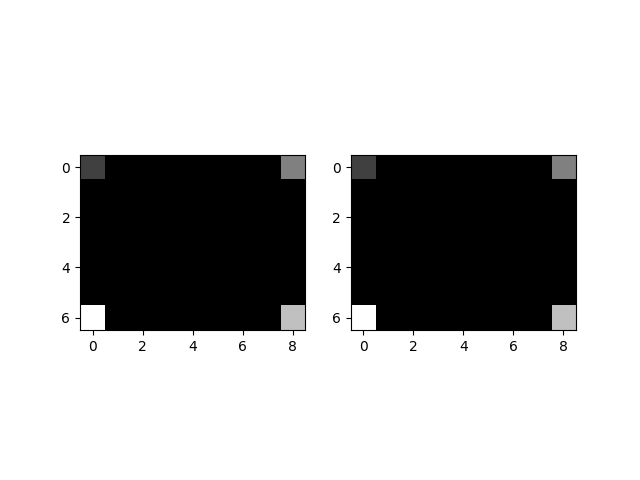

In [20]:
img = test_image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, cmap='gray')
axs[1].imshow(fourdstem_array.sum(axis=(1, 2)).reshape(ScanGrid.scan_shape), cmap='gray')

In [22]:
shifted_sum_image = np.zeros(model.scan_grid.scan_shape, dtype=np.float32)
shifted_sum_image = do_shifted_sum(shifted_sum_image, sample_px_ys, sample_px_xs, detector_intensities)

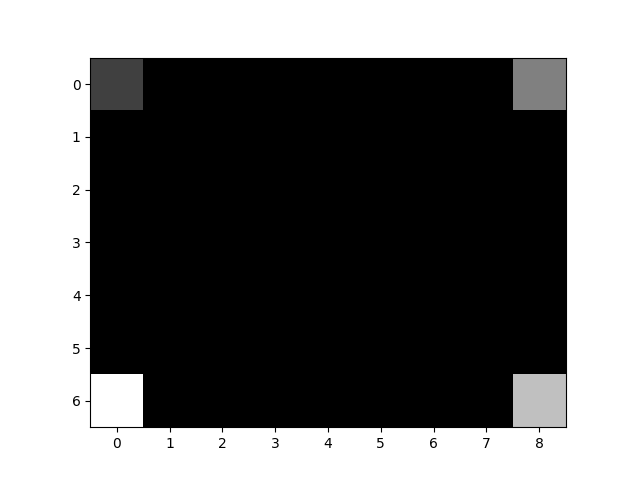

In [23]:
fig, ax = plt.subplots()
ax.imshow(shifted_sum_image, cmap='gray')